## Funcion

In [113]:
import json
import math
import networkx as nx
import matplotlib.pyplot as plt


def cargar_datos(json_files):
    data_comb = {"rs_info": None, "stations": set(), "services": {}, "cost_per_unit": {}}
    for file_path in json_files:
        with open(file_path, "r") as file:
            data = json.load(file)

        if data_comb["rs_info"] is None:
            data_comb["rs_info"] = data["rs_info"]

        data_comb["stations"].update(data["stations"])

        for service_id, service in data["services"].items():
            if service_id not in data_comb["services"]:
                data_comb["services"][service_id] = service

        data_comb["cost_per_unit"].update(data["cost_per_unit"])

    data_comb["stations"] = list(data_comb["stations"])
    return data_comb


def circulacion(data, dibujo=False):
    data = cargar_datos(data)

    # Crear el grafo dirigido
    G = nx.DiGraph()

    # Parámetros generales
    capacity = data["rs_info"]["capacity"]
    max_rs = data["rs_info"]["max_rs"]
    stations = data["stations"]
    cost_per_unit = data["cost_per_unit"]

    flujo_por_estacion = {station: 0 for station in stations}  

    # Agregar tren al grafo
    for service_id, service in data["services"].items():
        stops = service["stops"]
        demand = service["demand"][0]

        # Crear nodos para las estaciones
        salida = f"{service_id}_D"
        llegada = f"{service_id}_A"

        G.add_node(salida, station=stops[0]["station"], time=stops[0]["time"], demand=math.ceil(demand / capacity))
        G.add_node(llegada, station=stops[1]["station"], time=stops[1]["time"], demand=-math.ceil(demand / capacity))

        # Agregar arista
        G.add_edge(
            salida,
            llegada,
            lower=math.ceil(demand / capacity),
            upper=max_rs,
            costo=0,
            color="blue",
        )

    # Agregar traspaso por estación
    eventos_station = {station: [] for station in stations}
    for node, attributes in G.nodes(data=True):
        eventos_station[attributes["station"]].append((node, attributes["time"]))
      
    for station, events in eventos_station.items():
        events.sort(key=lambda x: x[1])
        for i in range(len(events) - 1):
            G.add_edge(
                events[i][0],
                events[i + 1][0],
                lower=0,
                upper=float("inf"),
                costo=0,
                color="red",
            )

    # Agregar trasnoche
    for station, events in eventos_station.items():
        if events:
            salida = events[0][0]
            llegada = events[-1][0]

            G.add_edge(
                llegada,
                salida,
                lower=0,
                upper=1e10,
                costo=cost_per_unit[station],
                color="green",
            )

    # Resolver flujo mínimo y calcular costos
    flow_cost, flow_dict = nx.capacity_scaling(G, demand="demand", weight="costo")

    # Mostrar resultados generales
    print("Costo mínimo (vagones):", flow_cost)
    print("\nFlujo por arco:")
    for u, v, attributes in G.edges(data=True):
        flujo = flow_dict.get(u, {}).get(v)
        print(f"{u} -> {v}: Flujo = {flujo}, Costo = {attributes['costo']}, Color: {attributes['color']}")
        if attributes["color"] == "green": #trenes de trasnoche con costo
            station_u = G.nodes[u]["station"]
            flujo_por_estacion[station_u] += flujo
    print(flujo_por_estacion)


    # Llamar a la función de dibujo si se solicita
    if dibujo:
        modelo(G, stations, flow_dict)




def modelo(G, stations, flow_dict):

    pos = {}
    offset = 10  
    for i, (node, datos) in enumerate(G.nodes(data=True)):
        station_i = stations.index(datos["station"]) 
        pos[node] = (datos["time"] + i * offset, station_i)  

    # Dibujar nodos
    nx.draw_networkx_nodes(
        G, 
        pos, 
        node_size=700, 
        node_color="skyblue", 
        alpha=0.8
    )

    # Dibujar etiquetas de nodos
    nx.draw_networkx_labels(
        G, 
        pos, 
        font_size=9, 
        font_weight="bold", 
        verticalalignment="center"
    )

    # Dibujar arcos con colores según el tipo de conexión
    for (u, v, datos) in G.edges(data=True):
        color = datos["color"]
        connectionstyle = "arc3,rad=0.2" if color == "green" else "arc3,rad=0"
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=[(u, v)],
            edge_color=color,
            width=2,
            arrowstyle="->",
            arrowsize=10,
            alpha=0.9,
            connectionstyle=connectionstyle,
        )

    # Agregar etiquetas de flujo a las aristas
    edge_labels = {}
    for u, v, datos in G.edges(data=True):
        color = datos["color"]
        flujo = flow_dict.get(u, {}).get(v, 0)  # Obtener el flujo entre u y v
        edge_labels[(u, v)] = f"{flujo}"


    # Dibujar etiquetas de las aristas (flujos)
    nx.draw_networkx_edge_labels(
        G,
        pos,
        edge_labels=edge_labels,
        font_size=8,
        font_color="black",
        label_pos= 0.5,  # Posición de la etiqueta en la arista
    )

    # Agregar título y ejes
    plt.title("Grafo de flujo de trenes", fontsize=16)
    plt.xlabel("Tiempo (Unidades de Tiempo)", fontsize=12)
    plt.ylabel("Estación", fontsize=12)

    plt.show()



## Modelo

Costo mínimo (vagones): 15.0

Flujo por arco:
1_D -> 1_A: Flujo = 0, Costo = 0, Color: blue
1_D -> 3_A: Flujo = 0, Costo = 0, Color: red
1_A -> 2_A: Flujo = 5, Costo = 0, Color: red
2_D -> 2_A: Flujo = 0, Costo = 0, Color: blue
2_D -> 4_A: Flujo = 0, Costo = 0, Color: red
2_A -> 3_D: Flujo = 10, Costo = 1.0, Color: green
3_D -> 3_A: Flujo = 0, Costo = 0, Color: blue
3_D -> 4_D: Flujo = 5, Costo = 0, Color: red
3_A -> 2_D: Flujo = 5, Costo = 0, Color: red
4_D -> 4_A: Flujo = 0, Costo = 0, Color: blue
4_D -> 1_A: Flujo = 0, Costo = 0, Color: red
4_A -> 1_D: Flujo = 5, Costo = 1.0, Color: green
{'Retiro': 5, 'Tigre': 10}


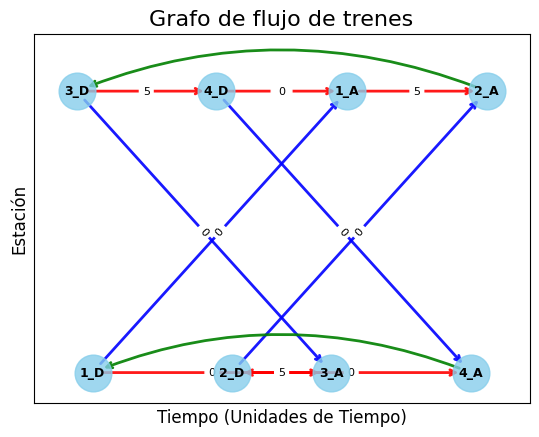

In [114]:
circulacion([r"../instances/toy_instance.json"], True)

## Ejercicio 4

JSON generado a partir de los datos de los horarios en pdf

In [103]:
data_comb = [r"../instances/victoria-cardales.json"]
circulacion(data_comb)

Costo mínimo (vagones): 8

Flujo por arco:
2001_D -> 2001_A: Flujo = 0, Costo = 0, Color: blue
2001_D -> 2002_A: Flujo = 4, Costo = 0, Color: red
2001_A -> 2002_D: Flujo = 4, Costo = 0, Color: red
2002_D -> 2002_A: Flujo = 0, Costo = 0, Color: blue
2002_D -> 2005_A: Flujo = 0, Costo = 0, Color: red
2002_A -> 2005_D: Flujo = 8, Costo = 0, Color: red
2005_D -> 2005_A: Flujo = 0, Costo = 0, Color: blue
2005_D -> 2007_D: Flujo = 4, Costo = 0, Color: red
2005_A -> 2006_D: Flujo = 4, Costo = 0, Color: red
2006_D -> 2006_A: Flujo = 0, Costo = 0, Color: blue
2006_D -> 2007_A: Flujo = 0, Costo = 0, Color: red
2006_A -> 2009_D: Flujo = 4, Costo = 0, Color: red
2007_D -> 2007_A: Flujo = 0, Costo = 0, Color: blue
2007_D -> 2006_A: Flujo = 0, Costo = 0, Color: red
2007_A -> 2008_D: Flujo = 4, Costo = 0, Color: red
2008_D -> 2008_A: Flujo = 0, Costo = 0, Color: blue
2008_D -> 2009_A: Flujo = 0, Costo = 0, Color: red
2008_A -> 2011_D: Flujo = 4, Costo = 0, Color: red
2009_D -> 2009_A: Flujo = 0, Cost

## Ejercicio 5
Creo un json a partir de los 3 y comparo con usar los ramales independientemente, no logramos que se muestre bien la diferencia real, suponemos que es algo de que pasen con el tiempo y solo toma un servicio. Sin embargo , en el informe hay una instancia simple de ejeplo para demostrar que es mejor en conjunto

JSON usando los valores en conjunto de los ramales:

In [104]:
data_comb = [r"../instances/retiro-tigre-semana.json",r"../instances/retiro-victoria-semana.json", r"../instances/tigre-victoria-semana.json", r"../instances/cardales-victoria-semana.json"]
circulacion(data_comb)

Costo mínimo (vagones): 65.0

Flujo por arco:
3001_D -> 3001_A: Flujo = 0, Costo = 0, Color: blue
3001_D -> 3003_D: Flujo = 5, Costo = 0, Color: red
3001_A -> 3022_D: Flujo = 5, Costo = 0, Color: red
3003_D -> 3003_A: Flujo = 0, Costo = 0, Color: blue
3003_D -> 3006_A: Flujo = 0, Costo = 0, Color: red
3003_A -> 3024_D: Flujo = 5, Costo = 0, Color: red
3005_D -> 3005_A: Flujo = 0, Costo = 0, Color: blue
3005_D -> 3008_A: Flujo = 0, Costo = 0, Color: red
3005_A -> 3026_D: Flujo = 5, Costo = 0, Color: red
3007_D -> 3007_A: Flujo = 9, Costo = 0, Color: blue
3007_D -> 3010_A: Flujo = 0, Costo = 0, Color: red
3007_A -> 3028_D: Flujo = 14, Costo = 0, Color: red
3009_D -> 3009_A: Flujo = 0, Costo = 0, Color: blue
3009_D -> 3012_A: Flujo = 0, Costo = 0, Color: red
3009_A -> 3030_D: Flujo = 9, Costo = 0, Color: red
3011_D -> 3011_A: Flujo = 0, Costo = 0, Color: blue
3011_D -> 3014_A: Flujo = 0, Costo = 0, Color: red
3011_A -> 3032_D: Flujo = 5, Costo = 0, Color: red
3013_D -> 3013_A: Flujo = 1, 

Calculo de forma independiente el uso de vagones para los dos ramales:

In [242]:

data_1= [r"../instances/tigre-victoria-semana.json"]
circulacion(data_1)

Costo mínimo (vagones): 45.0

Flujo por arco:
3001_D -> 3001_A: Flujo = 20, Costo = 0, Color: blue
3001_D -> 3018_A: Flujo = 5, Costo = 0, Color: red
3001_A -> 3022_D: Flujo = 25, Costo = 0, Color: red
3003_D -> 3003_A: Flujo = 10, Costo = 0, Color: blue
3003_D -> 3020_A: Flujo = 4, Costo = 0, Color: red
3003_A -> 3024_D: Flujo = 16, Costo = 0, Color: red
3005_D -> 3005_A: Flujo = 4, Costo = 0, Color: blue
3005_D -> 3022_A: Flujo = 1, Costo = 0, Color: red
3005_A -> 3026_D: Flujo = 9, Costo = 0, Color: red
3007_D -> 3007_A: Flujo = 20, Costo = 0, Color: blue
3007_D -> 3024_A: Flujo = 0, Costo = 0, Color: red
3007_A -> 3028_D: Flujo = 28, Costo = 0, Color: red
3009_D -> 3009_A: Flujo = 11, Costo = 0, Color: blue
3009_D -> 3026_A: Flujo = 0, Costo = 0, Color: red
3009_A -> 3030_D: Flujo = 20, Costo = 0, Color: red
3011_D -> 3011_A: Flujo = 1, Costo = 0, Color: blue
3011_D -> 3028_A: Flujo = 0, Costo = 0, Color: red
3011_A -> 3032_D: Flujo = 6, Costo = 0, Color: red
3013_D -> 3013_A: Fluj

In [105]:
#victoria- cardales
data_2 =   [r"../instances/retiro-victoria-semana.json"]
circulacion(data_2)

Costo mínimo (vagones): 50.0

Flujo por arco:
3001_D -> 3001_A: Flujo = 0, Costo = 0, Color: blue
3001_D -> 3003_D: Flujo = 5, Costo = 0, Color: red
3001_A -> 3018_D: Flujo = 5, Costo = 0, Color: red
3003_D -> 3003_A: Flujo = 0, Costo = 0, Color: blue
3003_D -> 3006_A: Flujo = 0, Costo = 0, Color: red
3003_A -> 3020_D: Flujo = 5, Costo = 0, Color: red
3005_D -> 3005_A: Flujo = 4, Costo = 0, Color: blue
3005_D -> 3008_A: Flujo = 0, Costo = 0, Color: red
3005_A -> 3022_D: Flujo = 9, Costo = 0, Color: red
3007_D -> 3007_A: Flujo = 5, Costo = 0, Color: blue
3007_D -> 3010_A: Flujo = 0, Costo = 0, Color: red
3007_A -> 3024_D: Flujo = 10, Costo = 0, Color: red
3009_D -> 3009_A: Flujo = 1, Costo = 0, Color: blue
3009_D -> 3012_A: Flujo = 0, Costo = 0, Color: red
3009_A -> 3026_D: Flujo = 6, Costo = 0, Color: red
3011_D -> 3011_A: Flujo = 0, Costo = 0, Color: blue
3011_D -> 3014_A: Flujo = 0, Costo = 0, Color: red
3011_A -> 3028_D: Flujo = 5, Costo = 0, Color: red
3013_D -> 3013_A: Flujo = 0, 

In [106]:
#victoria- cardales
data_2 =   [r"../instances/cardales-victoria-semana.json"]
circulacion(data_2)

Costo mínimo (vagones): 10.0

Flujo por arco:
2002_D -> 2002_A: Flujo = 0, Costo = 0, Color: blue
2002_D -> 2005_A: Flujo = 0, Costo = 0, Color: red
2002_A -> 2005_D: Flujo = 10, Costo = 0, Color: red
2006_D -> 2006_A: Flujo = 0, Costo = 0, Color: blue
2006_D -> 2007_A: Flujo = 0, Costo = 0, Color: red
2006_A -> 2009_D: Flujo = 5, Costo = 0, Color: red
2008_D -> 2008_A: Flujo = 0, Costo = 0, Color: blue
2008_D -> 2009_A: Flujo = 0, Costo = 0, Color: red
2008_A -> 2011_D: Flujo = 5, Costo = 0, Color: red
2010_D -> 2010_A: Flujo = 0, Costo = 0, Color: blue
2010_D -> 2011_A: Flujo = 0, Costo = 0, Color: red
2010_A -> 2013_D: Flujo = 5, Costo = 0, Color: red
2012_D -> 2012_A: Flujo = 0, Costo = 0, Color: blue
2012_D -> 2013_A: Flujo = 0, Costo = 0, Color: red
2012_A -> 2015_D: Flujo = 5, Costo = 0, Color: red
2014_D -> 2014_A: Flujo = 0, Costo = 0, Color: blue
2014_D -> 2015_A: Flujo = 0, Costo = 0, Color: red
2014_A -> 2017_D: Flujo = 5, Costo = 0, Color: red
2016_D -> 2016_A: Flujo = 0, 

## Experimentacion

### Demandas
Queriamos ver si cambiabamos la demanda cuanto cambiaba la cantidad de vagones necesarios y si la necesidad es lineal a la demanda

#### Demanda Baja:
Con demanda igual siempre en 100

In [108]:
path = [r"../instances/experimentacion/demandas/demanda_baja.json"]
circulacion(path)

Costo mínimo (vagones): 2

Flujo por arco:
2001_D -> 2001_A: Flujo = 0, Costo = 0, Color: blue
2001_D -> 2002_A: Flujo = 1, Costo = 0, Color: red
2001_A -> 2002_D: Flujo = 1, Costo = 0, Color: red
2002_D -> 2002_A: Flujo = 0, Costo = 0, Color: blue
2002_D -> 2005_A: Flujo = 0, Costo = 0, Color: red
2002_A -> 2005_D: Flujo = 2, Costo = 0, Color: red
2005_D -> 2005_A: Flujo = 0, Costo = 0, Color: blue
2005_D -> 2007_D: Flujo = 1, Costo = 0, Color: red
2005_A -> 2006_D: Flujo = 1, Costo = 0, Color: red
2006_D -> 2006_A: Flujo = 0, Costo = 0, Color: blue
2006_D -> 2007_A: Flujo = 0, Costo = 0, Color: red
2006_A -> 2009_D: Flujo = 1, Costo = 0, Color: red
2007_D -> 2007_A: Flujo = 0, Costo = 0, Color: blue
2007_D -> 2006_A: Flujo = 0, Costo = 0, Color: red
2007_A -> 2008_D: Flujo = 1, Costo = 0, Color: red
2008_D -> 2008_A: Flujo = 0, Costo = 0, Color: blue
2008_D -> 2009_A: Flujo = 0, Costo = 0, Color: red
2008_A -> 2011_D: Flujo = 1, Costo = 0, Color: red
2009_D -> 2009_A: Flujo = 0, Cost

#### Demanda Alta:
Con demanda en todas las estaciones constante en 1000 

In [109]:
path = [r"../instances/experimentacion/demandas/demanda_alta.json"]
circulacion(path)

Costo mínimo (vagones): 20

Flujo por arco:
2001_D -> 2001_A: Flujo = 0, Costo = 0, Color: blue
2001_D -> 2002_A: Flujo = 10, Costo = 0, Color: red
2001_A -> 2002_D: Flujo = 10, Costo = 0, Color: red
2002_D -> 2002_A: Flujo = 0, Costo = 0, Color: blue
2002_D -> 2005_A: Flujo = 0, Costo = 0, Color: red
2002_A -> 2005_D: Flujo = 20, Costo = 0, Color: red
2005_D -> 2005_A: Flujo = 0, Costo = 0, Color: blue
2005_D -> 2007_D: Flujo = 10, Costo = 0, Color: red
2005_A -> 2006_D: Flujo = 10, Costo = 0, Color: red
2006_D -> 2006_A: Flujo = 0, Costo = 0, Color: blue
2006_D -> 2007_A: Flujo = 0, Costo = 0, Color: red
2006_A -> 2009_D: Flujo = 10, Costo = 0, Color: red
2007_D -> 2007_A: Flujo = 0, Costo = 0, Color: blue
2007_D -> 2006_A: Flujo = 0, Costo = 0, Color: red
2007_A -> 2008_D: Flujo = 10, Costo = 0, Color: red
2008_D -> 2008_A: Flujo = 0, Costo = 0, Color: blue
2008_D -> 2009_A: Flujo = 0, Costo = 0, Color: red
2008_A -> 2011_D: Flujo = 10, Costo = 0, Color: red
2009_D -> 2009_A: Flujo 

In [110]:
path= [r"../instances/experimentacion/demandas/demanda_mixta.json"]
circulacion(path)

Costo mínimo (vagones): 34

Flujo por arco:
2001_D -> 2001_A: Flujo = 22, Costo = 0, Color: blue
2001_D -> 2002_A: Flujo = 6, Costo = 0, Color: red
2001_A -> 2002_D: Flujo = 28, Costo = 0, Color: red
2002_D -> 2002_A: Flujo = 0, Costo = 0, Color: blue
2002_D -> 2005_A: Flujo = 16, Costo = 0, Color: red
2002_A -> 2005_D: Flujo = 18, Costo = 0, Color: red
2005_D -> 2005_A: Flujo = 7, Costo = 0, Color: blue
2005_D -> 2007_D: Flujo = 6, Costo = 0, Color: red
2005_A -> 2006_D: Flujo = 28, Costo = 0, Color: red
2006_D -> 2006_A: Flujo = 0, Costo = 0, Color: blue
2006_D -> 2007_A: Flujo = 8, Costo = 0, Color: red
2006_A -> 2009_D: Flujo = 20, Costo = 0, Color: red
2007_D -> 2007_A: Flujo = 3, Costo = 0, Color: blue
2007_D -> 2006_A: Flujo = 0, Costo = 0, Color: red
2007_A -> 2008_D: Flujo = 14, Costo = 0, Color: red
2008_D -> 2008_A: Flujo = 0, Costo = 0, Color: blue
2008_D -> 2009_A: Flujo = 0, Costo = 0, Color: red
2008_A -> 2011_D: Flujo = 14, Costo = 0, Color: red
2009_D -> 2009_A: Flujo 

### Capacidad

In [116]:
path = [r"../instances/experimentacion/capacidad/capacidad2.json"]
circulacion(path, False)

Costo mínimo (vagones): 3.0

Flujo por arco:
1_D -> 1_A: Flujo = 0, Costo = 0, Color: blue
1_D -> 4_A: Flujo = 0, Costo = 0, Color: red
1_A -> 4_D: Flujo = 3, Costo = 0, Color: red
2_D -> 2_A: Flujo = 0, Costo = 0, Color: blue
2_D -> 3_A: Flujo = 0, Costo = 0, Color: red
2_A -> 3_D: Flujo = 3, Costo = 0, Color: red
3_D -> 3_A: Flujo = 0, Costo = 0, Color: blue
3_D -> 1_A: Flujo = 0, Costo = 1.0, Color: green
3_A -> 1_D: Flujo = 3, Costo = 1.0, Color: green
4_D -> 4_A: Flujo = 0, Costo = 0, Color: blue
4_D -> 2_A: Flujo = 0, Costo = 0, Color: red
4_A -> 2_D: Flujo = 3, Costo = 0, Color: red
{'Retiro': 3, 'Tigre': 0}


In [115]:
path = [r"../instances/experimentacion/capacidad/capacidad.json"]
circulacion(path, False)

Costo mínimo (vagones): 2.0

Flujo por arco:
1_D -> 1_A: Flujo = 0, Costo = 0, Color: blue
1_D -> 4_A: Flujo = 0, Costo = 0, Color: red
1_A -> 4_D: Flujo = 2, Costo = 0, Color: red
2_D -> 2_A: Flujo = 0, Costo = 0, Color: blue
2_D -> 3_A: Flujo = 0, Costo = 0, Color: red
2_A -> 3_D: Flujo = 2, Costo = 0, Color: red
3_D -> 3_A: Flujo = 0, Costo = 0, Color: blue
3_D -> 1_A: Flujo = 0, Costo = 1.0, Color: green
3_A -> 1_D: Flujo = 2, Costo = 1.0, Color: green
4_D -> 4_A: Flujo = 0, Costo = 0, Color: blue
4_D -> 2_A: Flujo = 0, Costo = 0, Color: red
4_A -> 2_D: Flujo = 2, Costo = 0, Color: red
{'Retiro': 2, 'Tigre': 0}


### Frecuencia

Costo mínimo (vagones): 10.0

Flujo por arco:
1_D -> 1_A: Flujo = 0, Costo = 0, Color: blue
1_D -> 2_D: Flujo = 4, Costo = 0, Color: red
1_A -> 6_D: Flujo = 2, Costo = 0, Color: red
2_D -> 2_A: Flujo = 0, Costo = 0, Color: blue
2_D -> 3_D: Flujo = 2, Costo = 0, Color: red
2_A -> 3_A: Flujo = 2, Costo = 0, Color: red
3_D -> 3_A: Flujo = 0, Costo = 0, Color: blue
3_D -> 4_A: Flujo = 0, Costo = 0, Color: red
3_A -> 4_D: Flujo = 4, Costo = 1.0, Color: green
4_D -> 4_A: Flujo = 0, Costo = 0, Color: blue
4_D -> 5_D: Flujo = 2, Costo = 0, Color: red
4_A -> 5_A: Flujo = 2, Costo = 0, Color: red
5_D -> 5_A: Flujo = 0, Costo = 0, Color: blue
5_D -> 1_A: Flujo = 0, Costo = 0, Color: red
5_A -> 6_A: Flujo = 4, Costo = 0, Color: red
6_D -> 6_A: Flujo = 0, Costo = 0, Color: blue
6_D -> 2_A: Flujo = 0, Costo = 0, Color: red
6_A -> 1_D: Flujo = 6, Costo = 1.0, Color: green
{'Retiro': 6, 'Tigre': 4}


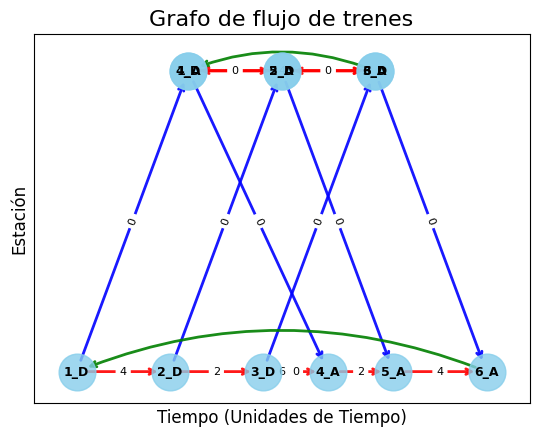

In [118]:
path = [r"../instances/experimentacion/frecuencia/costo_30.json"]
circulacion(path, True)

Costo mínimo (vagones): 9.0

Flujo por arco:
1_D -> 1_A: Flujo = 0, Costo = 0
1_D -> 2_D: Flujo = 3, Costo = 0
1_A -> 4_D: Flujo = 3, Costo = 0
2_D -> 2_A: Flujo = 0, Costo = 0
2_D -> 3_A: Flujo = 0, Costo = 0
2_A -> 3_D: Flujo = 3, Costo = 1.0
3_D -> 3_A: Flujo = 0, Costo = 0
3_D -> 1_A: Flujo = 0, Costo = 0
3_A -> 4_A: Flujo = 3, Costo = 0
4_D -> 4_A: Flujo = 0, Costo = 0
4_D -> 2_A: Flujo = 0, Costo = 0
4_A -> 1_D: Flujo = 6, Costo = 1.0


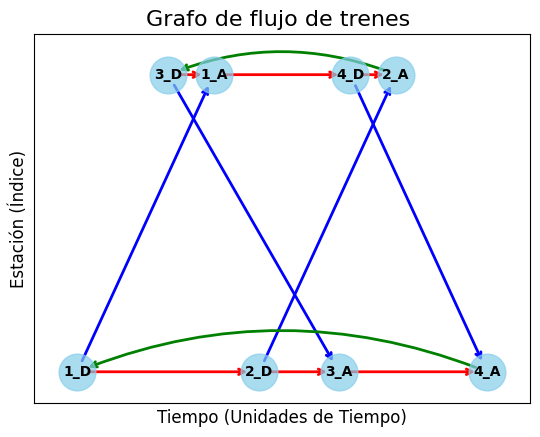

In [ ]:
path = [r"../instances/experimentacion/frecuencia/costo_60.json"]
circulacion(path, True)

In [117]:
path = [r"../instances/experimentacion/frecuencia/frecuencia_alta.json"]
circulacion(path, False)

Costo mínimo (vagones): 8.0

Flujo por arco:
1_D -> 1_A: Flujo = 0, Costo = 0, Color: blue
1_D -> 2_D: Flujo = 4, Costo = 0, Color: red
1_A -> 6_D: Flujo = 4, Costo = 0, Color: red
2_D -> 2_A: Flujo = 0, Costo = 0, Color: blue
2_D -> 6_A: Flujo = 0, Costo = 0, Color: red
2_A -> 7_D: Flujo = 4, Costo = 0, Color: red
3_D -> 3_A: Flujo = 0, Costo = 0, Color: blue
3_D -> 7_A: Flujo = 0, Costo = 0, Color: red
3_A -> 8_D: Flujo = 4, Costo = 0, Color: red
4_D -> 4_A: Flujo = 0, Costo = 0, Color: blue
4_D -> 8_A: Flujo = 0, Costo = 0, Color: red
4_A -> 9_D: Flujo = 4, Costo = 0, Color: red
5_D -> 5_A: Flujo = 0, Costo = 0, Color: blue
5_D -> 9_A: Flujo = 0, Costo = 0, Color: red
5_A -> 10_D: Flujo = 4, Costo = 0, Color: red
6_D -> 6_A: Flujo = 3, Costo = 0, Color: blue
6_D -> 2_A: Flujo = 0, Costo = 0, Color: red
6_A -> 3_D: Flujo = 4, Costo = 0, Color: red
7_D -> 7_A: Flujo = 3, Costo = 0, Color: blue
7_D -> 3_A: Flujo = 0, Costo = 0, Color: red
7_A -> 4_D: Flujo = 4, Costo = 0, Color: red
8_